In [1]:
from __future__ import division
import math
import numpy as np
import torch
from torchvision.models.alexnet import alexnet
from torchvision.models.vgg import vgg16, vgg19
from torchvision.models.resnet import resnet18, resnet50
from torchvision.models.densenet import densenet121
from torchvision.models.inception import Inception3 as inception3
import sys
import time
import random
import gc

sys.path.append('../../../code')

from python.commons import full_inference_e2e_with_model, inc_inference_e2e_with_model
from python.vgg16 import VGG16
from python.resnet18 import ResNet18
from python.inception3 import Inception3

from torch.autograd import Variable

import matplotlib.pyplot as plt
from plot_commons import get_ivm_patch_coordinates, calculate_ivm_flops, calculate_flops, mean_confidence_interval

random.seed(45)
np.random.seed(45)

torch.set_num_threads(8)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


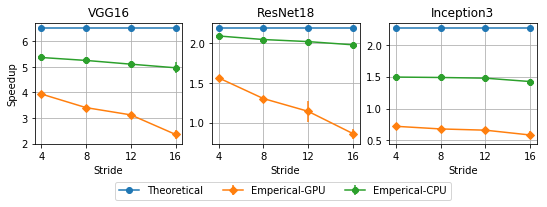

In [2]:
models = ["VGG16", "ResNet18", "Inception3"]
strides = [4, 8, 12, 16]
dataset = "OCT"
runs = 4
image_file_path = '../../../code/python/dog_resized.jpg'
patch_size = 16
c = 0.0

log_file = open('5_2_1_b.log', 'a')
log_file.write("============================================\n")
log_file.flush()
    
plt.figure(figsize=(9,2.5))

for idx, model in enumerate(models):
    if model == "VGG16":
        torch_model = vgg16()
        ivm_model = VGG16
        image_size = 224
    elif model == "ResNet18":
        torch_model = resnet18()
        ivm_model = ResNet18
        image_size = 224
    elif model == "Inception3":
        torch_model = inception3()
        ivm_model = Inception3
        image_size = 299
        
    x = Variable(torch.from_numpy(np.zeros(shape=(1, 3, image_size, image_size), dtype=np.float32)))
    
    ax = plt.subplot(1, 3, idx+1)
    
    with torch.onnx.set_training(torch_model, False):
        trace, _ = torch.jit.get_trace_graph(torch_model, args=(x,))
        
    torch.onnx._optimize_trace(trace, False)
    graph = trace.graph()
    
    r = []
    for stride in strides:

        full_flops = calculate_flops(model, x, debug=False, graph=graph) / (1000 ** 2)
        i = (224-patch_size)//2
        j = (224-patch_size)//2
        ivm_flops = calculate_ivm_flops(model, x, patch_size, patch_size, i, j, debug=False,
                                        graph=graph, tau=1.0) / (1000 ** 2)

        #print(name, patch_size, full_flops, ivm_flops, full_flops/ivm_flops)
        r.append(full_flops/ivm_flops)

    plt.plot([2, 4, 6, 8], r, label='Theoretical', marker='o')
    
    gpu_emperical_mean = []
    gpu_emperical_ci = []

    cpu_emperical_mean = []
    cpu_emperical_ci = []
    
    gpu_naive_mean = []
    gpu_naive_ci = []
    
        
    for stride in strides:
        
        temp_runs_gpu = []
        temp_runs_cpu = []
        temp_runs_gpu_naive = []
        
        full_inference_times = []
        torch_model = ivm_model(gpu=True)
        for count in range(runs):
            torch.cuda.synchronize()
            prev_time = time.time()
            with torch.no_grad():
                x, prob, logit_index = full_inference_e2e_with_model(torch_model, image_file_path, patch_size, stride,
                                       batch_size=128, gpu=True, image_size=image_size, x_size=image_size,
                                       y_size=image_size, c=c)
            torch.cuda.synchronize()
            full_inference_time = time.time() - prev_time
            log_file.write(",".join([str(x) for x in [model, stride, count, "full-gpu", full_inference_time]])+"\n")
            log_file.flush()
            full_inference_times.append(full_inference_time)
        del torch_model
        gc.collect()
            
        torch_model = ivm_model(gpu=True)
        for count in range(runs):
            torch.cuda.synchronize()    
            prev_time = time.time()
            with torch.no_grad():
                x, prob, logit_index = inc_inference_e2e_with_model(torch_model, image_file_path, patch_size, stride,
                                      batch_size=128, beta=1.0, gpu=True, version='v1',
                                     image_size=image_size, x_size=image_size, y_size=image_size, c=c)
            torch.cuda.synchronize()
            inc_inference_time = time.time() - prev_time
            
            temp_runs_gpu.append(full_inference_times[count]*1.0/inc_inference_time)
            log_file.write(",".join([str(x) for x in [model, stride, count, "inc-gpu", inc_inference_time]])+"\n")
            log_file.flush()
        del torch_model
        gc.collect()
            
        
        full_inference_times = []
        torch_model = ivm_model(gpu=False)
        for count in range(runs-1):
            torch.cuda.synchronize()
            prev_time = time.time()
            with torch.no_grad():
                x, prob, logit_index = full_inference_e2e_with_model(torch_model, image_file_path, patch_size, stride,
                                       batch_size=16, gpu=False, image_size=image_size, x_size=image_size,
                                       y_size=image_size, c=c)
            torch.cuda.synchronize()
            full_inference_time = time.time() - prev_time
            log_file.write(",".join([str(x) for x in [model, stride, count, "full-cpu", full_inference_time]])+"\n")
            log_file.flush()
            full_inference_times.append(full_inference_time)
        del torch_model
        gc.collect()
        
        torch_model = ivm_model(gpu=False)
        for count in range(runs-1):
            torch.cuda.synchronize()    
            prev_time = time.time()
            with torch.no_grad():
                x, prob, logit_index = inc_inference_e2e_with_model(torch_model, image_file_path, patch_size, stride,
                                      batch_size=16, beta=1.0, gpu=False, version='v2',
                                     image_size=image_size, x_size=image_size, y_size=image_size, c=c)
            torch.cuda.synchronize()
            inc_inference_time = time.time() - prev_time
            
            temp_runs_cpu.append(full_inference_times[count]*1.0/inc_inference_time)
            log_file.write(",".join([str(x) for x in [model, stride, count, "inc-cpu", inc_inference_time]])+"\n")
            log_file.flush()
        del torch_model
        gc.collect()
                    
        m, ci = mean_confidence_interval(temp_runs_gpu[1:])
        gpu_emperical_mean.append(m)
        gpu_emperical_ci.append(ci)       
        
        m, ci = mean_confidence_interval(temp_runs_cpu)
        cpu_emperical_mean.append(m)
        cpu_emperical_ci.append(ci)
    
    ax.errorbar([2, 4, 6, 8], gpu_emperical_mean, yerr=gpu_emperical_ci, marker='D', label='Emperical-GPU')
    ax.errorbar([2, 4, 6, 8], cpu_emperical_mean, yerr=cpu_emperical_ci, marker='8', label='Emperical-CPU')
    
    ax.set_title(model)
    plt.grid()
    if idx == 0:
        plt.ylabel('Speedup')

    plt.xlabel('Stride')
    plt.xticks([2, 4, 6, 8], strides)

plt.subplots_adjust(top=0.8)
lgd = plt.legend(loc='lower center', ncol=4, bbox_to_anchor=[-0.72, -.5])

plt.savefig('../images/5_2_1_b.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')    
plt.show()

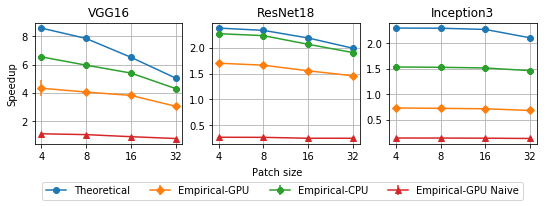

In [4]:
models = ["VGG16", "ResNet18", "Inception3"]
patch_sizes = [4, 8, 16, 32]
dataset = "OCT"
runs = 4
stride = 4
c = 0.0

log_file = open('5_2_1.log', 'r')
lines = log_file.readlines()[1:]

fig = plt.figure(figsize=(9,2.5))

count = 0
for idx, model in enumerate(models):
    if model == "VGG16":
        torch_model = vgg16()
        image_size = 224
    elif model == "ResNet18":
        torch_model = resnet18()
        image_size = 224
    elif model == "Inception3":
        torch_model = inception3()
        image_size = 299
        
    x = Variable(torch.from_numpy(np.zeros(shape=(1, 3, image_size, image_size), dtype=np.float32)))
    
    ax = plt.subplot(1, 3, idx+1)
    
    with torch.onnx.set_training(torch_model, False):
        trace, _ = torch.jit.get_trace_graph(torch_model, args=(x,))
        
    torch.onnx._optimize_trace(trace, False)
    graph = trace.graph()
    
    r = []
    for patch_size in patch_sizes:

        full_flops = calculate_flops(model, x, debug=False, graph=graph) / (1000 ** 2)
        i = (224-patch_size)//2
        j = (224-patch_size)//2
        ivm_flops = calculate_ivm_flops(model, x, patch_size, patch_size, i, j, debug=False,
                                        graph=graph, tau=1.0) / (1000 ** 2)

        #print(name, patch_size, full_flops, ivm_flops, full_flops/ivm_flops)
        r.append(full_flops/ivm_flops)

    plt.plot([2, 4, 6, 8], r, label='Theoretical', marker='o')
    
    gpu_emperical_mean = []
    gpu_emperical_ci = []

    cpu_emperical_mean = []
    cpu_emperical_ci = []
    
    gpu_naive_mean = []
    gpu_naive_ci = []
    
    for patch_size in patch_sizes:
        temp = []
        full_inference_times = []
        for r in range(runs):
            full_inference_times.append(float(lines[count].split(",")[-1].replace("\n", "")))
            count += 1
            
        for r in range(runs):
            temp.append(full_inference_times[r]/float(lines[count].split(",")[-1].replace("\n", "")))
            count += 1
            
        m, ci = mean_confidence_interval(temp)
        gpu_emperical_mean.append(m)
        gpu_emperical_ci.append(ci)
        
        temp = []
        for r in range(runs):
            temp.append(full_inference_times[r]/float(lines[count].split(",")[-1].replace("\n", "")))
            count += 1
            
        m, ci = mean_confidence_interval(temp)
        gpu_naive_mean.append(m)
        gpu_naive_ci.append(ci)
        
        temp = []
        full_inference_times = []
        for r in range(runs-1):
            full_inference_times.append(float(lines[count].split(",")[-1].replace("\n", "")))
            count += 1
            
        for r in range(runs-1):
            temp.append(full_inference_times[r]/float(lines[count].split(",")[-1].replace("\n", "")))
            count += 1
            
        m, ci = mean_confidence_interval(temp)
        cpu_emperical_mean.append(m)
        cpu_emperical_ci.append(ci)
    
    #plt.plot(patch_sizes, r, label='Emperical-GPU', marker='o')
    ax.errorbar([2, 4, 6, 8], gpu_emperical_mean, yerr=gpu_emperical_ci, marker='D', label='Empirical-GPU')
    ax.errorbar([2, 4, 6, 8], cpu_emperical_mean, yerr=cpu_emperical_ci, marker='8', label='Empirical-CPU')
    ax.errorbar([2, 4, 6, 8], gpu_naive_mean, yerr=gpu_naive_ci, marker='^', label='Empirical-GPU Naive')
    
    ax.set_title(model)
    plt.grid()
    if idx == 0:
        plt.ylabel('Speedup')

    #plt.xlabel('Patch Size')
    plt.xticks([2, 4, 6, 8], patch_sizes)

fig.text(0.5, -.05, "Patch size", ha='center')
plt.subplots_adjust(top=0.8)
lgd = plt.legend(loc='lower center', ncol=4, bbox_to_anchor=[-0.72, -.5])

plt.savefig('../images/5_2_1.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')    
plt.show()